In [0]:
!rm -r spark*
!apt-get install openjdk-8-jdk-headless -qq
!wget -q http://mirrors.koehn.com/apache/spark/spark-3.0.0-preview2/spark-3.0.0-preview2-bin-hadoop3.2.tgz
!tar xf spark-3.0.0-preview2-bin-hadoop3.2.tgz
!pip install -q findspark


In [0]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.0.0-preview2-bin-hadoop3.2"

import findspark
findspark.init()
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, udf
from pyspark.ml.feature import VectorAssembler, PCA
from pyspark.ml.clustering import KMeans
from pyspark.mllib.recommendation import ALS, Rating
from pyspark.ml.linalg import Vectors, VectorUDT
spark = SparkSession.builder.master("local[*]").getOrCreate()
sc = spark.sparkContext

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np

In [318]:
!unzip ml-100k.zip
rawData = sc.textFile("ml-100k/u.data")
rawRatings = rawData.map(lambda s: s.split("\t")[0:3])
ratings = rawRatings.map(lambda l: Rating(int(l[0]), int(l[1]), float(l[2])))

Archive:  ml-100k.zip
replace ml-100k/allbut.pl? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


In [0]:
# Question 1
als_model = ALS.train(ratings, 50, 10)
prodFeat = als_model.productFeatures().toDF()

kmeans = KMeans(featuresCol='_2', k=5)
kmeans_model = kmeans.fit(prodFeat)
prodFeat = kmeans_model.transform(prodFeat)

results = np.array(prodFeat.select('_1', 'prediction').collect())

np.savetxt('movie_labels.csv', results, delimiter=',', fmt='%i')

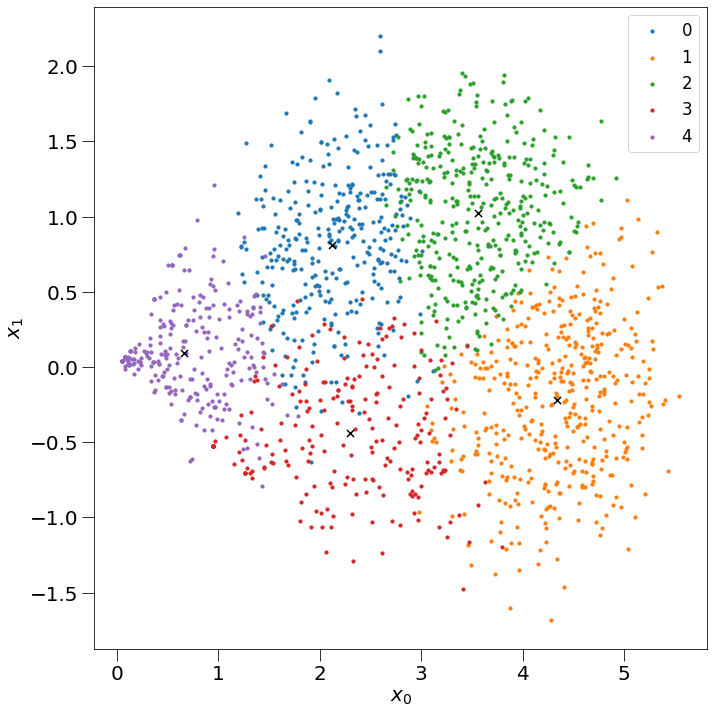

In [320]:
# Question 2

# Need to turn list of latent factors into PySpark Vector to do PCA
list_to_vector_udf = udf(lambda l: Vectors.dense(l), VectorUDT())
prodFeat = prodFeat.select(
    prodFeat['_1'], 
    list_to_vector_udf(prodFeat['_2']).alias('_2'),
    prodFeat['prediction'])

pca = PCA(k=2, inputCol="_2", outputCol="pcaFeatures")
pca_model = pca.fit(prodFeat)
data = pca_model.transform(prodFeat)

height = 10
width = 10

mpl.rcParams['figure.figsize'] = (width, height)
mpl.rcParams['font.size'] = 20
mpl.rcParams['legend.fontsize'] = 'small'
mpl.rcParams['xtick.major.size'] = 12
mpl.rcParams['xtick.minor.size'] = 8
mpl.rcParams['xtick.labelsize'] = 20
mpl.rcParams['ytick.major.size'] = 12
mpl.rcParams['ytick.minor.size'] = 8
mpl.rcParams['ytick.labelsize'] = 20

data_list = data.collect()
x = np.asarray([np.asarray(data_list[i]['pcaFeatures']) for i in range(len(data_list))])
labels = np.asarray([np.asarray(data_list[i]['prediction']) for i in range(len(data_list))])
centroids = np.array([x[labels==i].mean(axis=0) for i in range(5)])

cmap = plt.cm.get_cmap('tab10')
fig, ax = plt.subplots()
for cluster in np.unique(labels):
  ax.scatter(x[:,0][labels == cluster], x[:,1][labels == cluster], 10, c=np.array([cmap(cluster)]), label=cluster)
  ax.scatter(centroids[cluster,0], centroids[cluster,1], 50, marker='x', color='black')
ax.set_xlabel(r'$x_0$')
ax.set_ylabel(r'$x_1$')
ax.legend()
fig.tight_layout(pad=0.5)
fig.savefig('a4_q2.png', dpi=200)

In [0]:
# Quesion 3
rawData2 = sc.textFile("ml-100k/u.item")
rawMovies = rawData2.map(lambda s: s.split("|"))
rawData3 = sc.textFile('ml-100k/u.genre')
rawGenres = rawData3.map(lambda s: s.split("|"))
genre_data = rawMovies.toDF().select('_6', '_7', '_8', '_9', '_10', '_11', '_12','_13', '_14', '_15',
                                   '_16', '_17', '_18', '_19', '_20', '_21', '_22', '_23', '_24').collect()
movie_names = np.array(rawMovies.toDF().select('_2').collect()).flatten()
genre_data = np.asarray([np.asarray(genre_data[i]) for i in range(len(data_list))], dtype=np.int)
genre_key = rawGenres.collect()

genre_dict = {int(genre_key[i][1]):genre_key[i][0] for i in range(19)}
lf = np.asarray([np.asarray(data_list[i]['_2']) for i in range(len(data_list))])
centroids = np.array([lf[labels==i].mean(axis=0) for i in range(5)])
movie_id = np.array(prodFeat.select('_1').collect()).flatten()

for cluster in np.unique(labels):
  dist = np.sqrt(((lf[labels==cluster] - centroids[cluster])**2).sum(axis=1))
  top20 = np.argsort(dist)[:20]
  cluster_movies = movie_id[labels==cluster][top20]

  movie_inds, genre_inds = np.where(genre_data[cluster_movies] == 1)
  cluster_genres = {movie: [] for movie in cluster_movies}
  cluster_names = {movie: movie_names[movie] for movie in cluster_movies}
  for i, m in enumerate(movie_inds):
    cluster_genres[cluster_movies[m]].append(genre_dict[genre_inds[i]])
  with open('movies_c{}.txt'.format(cluster), 'w+') as file:
    print('MovieID,Distance,Name,Genres', file=file)
    for i, m in enumerate(cluster_movies):
      print('{},{:.3f},{},{}'.format(m, dist[top20][i], cluster_names[m], cluster_genres[m]), file=file)